In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
moons = pd.DataFrame( np.load("moon-all-input.npy") )
moons.columns = ["x1", "x2"]
moons

,x1,x2
0,1.538699,0.188744
1,0.394699,0.323724
2,-0.919147,1.311882
3,1.053964,-0.700408
4,1.040678,-0.437339
...,...,...
495,1.163768,-0.710319
496,0.477238,-0.681340
497,-0.246390,0.709156
498,0.897480,0.382935


In [65]:
moons["category"] = pd.DataFrame(np.load("moon-all-output.npy"))

In [66]:
moons

,x1,x2,category
0,1.538699,0.188744,1
1,0.394699,0.323724,0
2,-0.919147,1.311882,0
3,1.053964,-0.700408,1
4,1.040678,-0.437339,1
...,...,...,...
495,1.163768,-0.710319,1
496,0.477238,-0.681340,1
497,-0.246390,0.709156,0
498,0.897480,0.382935,0


<Axes: xlabel='x1', ylabel='x2'>

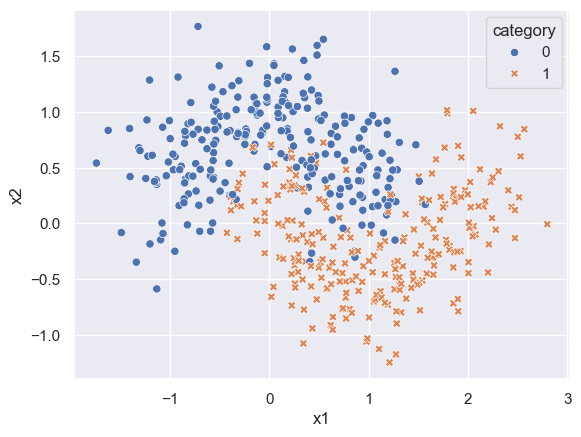

In [71]:
sns.set_theme()
sns.color_palette("Set2")
sns.scatterplot(data = moons, x="x1", y="x2", hue = "category", style = "category")


In [68]:
moon_train, moon_test = moons.iloc[:375], moons.iloc[375:]
moon_train

,x1,x2,category
0,1.538699,0.188744,1
1,0.394699,0.323724,0
2,-0.919147,1.311882,0
3,1.053964,-0.700408,1
4,1.040678,-0.437339,1
...,...,...,...
370,0.435785,-0.186108,1
371,-0.565615,0.563578,0
372,-1.205374,1.285517,0
373,0.515727,-0.347822,1


In [69]:
moon_test

,x1,x2,category
375,0.501693,0.217172,1
376,0.227405,0.589937,1
377,0.268167,0.431114,1
378,1.312708,-0.595236,1
379,0.418356,-0.382677,1
...,...,...,...
495,1.163768,-0.710319,1
496,0.477238,-0.681340,1
497,-0.246390,0.709156,0
498,0.897480,0.382935,0


In [70]:

X_train = moon_train.iloc[:, :2].copy()
y_train = moon_train.iloc[:, 2].copy()

X_test = moon_test.iloc[:, :2].copy()
y_test = moon_test.iloc[:, 2].copy()


The data is largely balanced with the ratio being 0.344 instead of 0.333

In [41]:
moon_train["category"].sum(), moon_test["category"].sum()

(186, 64)

AdaBoost

In [42]:
from sklearn.tree import DecisionTreeClassifier

import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)


class Classifier():
    classifier = None
    sample_weights = None
    error_weight = None
    classifier_weight = None
    learning_weight = 1
    X = None
    y = None
    y_pred = None

    def __init__(self, X, y, sample_weights, learning_rate=1):
        self.sample_weights = sample_weights
        self.learning_weight = learning_rate
        self.classifier = DecisionTreeClassifier(max_depth=1, random_state=42)
        self.X = X
        self.y = y

        self.classifier.fit(
            X, y, sample_weight=np.array(sample_weights).ravel())

    def calc_error(self):
        self.y_pred = self.classifier.predict(self.X)
        misclassified = self.sample_weights[self.y_pred != self.y]

        self.error_weight = misclassified.sum() / self.sample_weights.sum()

        return self.error_weight

    def calc_classifier_weight(self):
        self.calc_error()
        self.classifier_weight = (
            self.learning_weight * np.log((1-self.error_weight) / self.error_weight)).item()

        return self.classifier_weight

    def get_classifier_weight(self):
        return self.classifier_weight

    def get_new_sample_weights(self):
        self.calc_classifier_weight()

        current_weights = np.array(self.sample_weights)
        new_weights = np.empty(len(self.y_pred))
        pos_factor = np.exp(self.classifier_weight)
        neg_factor = np.exp(-self.classifier_weight)

        for i in range(len(self.y_pred)):
            if self.y_pred[i] != self.y[i]:
                new_weights[i] = current_weights[i] * pos_factor
            else:
                new_weights[i] = current_weights[i]
                # Slides contradict whether this should be the original value or the original * neg_factor
                # new_weights[i] = current_weights[i] * neg_factor
                
        # Normalizing the weights
        new_weights = new_weights / np.sum(new_weights)
        return new_weights

    def predict(self, X):
        return self.classifier.predict(X).item()


In [43]:
class AdaBoost():

    n_estimators = None
    classifiers = None
    X = None
    y = None
    learning_rate = 1

    def __init__(self, X, y, n_estimators=1, learning_rate=1):
        self.n_estimators = n_estimators
        self.classifiers = [None] * n_estimators
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.weights = None
        self.error_rates = None

    def fit(self):
        # Initializes the weights for all samples to 1/N, where N is the number of data points
        init_sample_weights = np.array(len(self.X) * [1/len(self.X)])
        self.classifiers[0] = Classifier(self.X, self.y, init_sample_weights)
        self.classifiers[0].calc_classifier_weight()

        for i in range(1, self.n_estimators):
            self.classifiers[i] = Classifier(
                self.X, self.y, self.classifiers[i-1].get_new_sample_weights())

        self.classifiers[-1].calc_classifier_weight()

        self.weights = np.array(
            [clf.classifier_weight for clf in self.classifiers])

        self.error_rates = np.array(
            [clf.error_weight for clf in self.classifiers])

    def predict_sample(self, X, start, stop):
        voting_clfs = self.classifiers[start:stop]
        weight = self.weights[start:stop]
        # Calculate classifier weights for all classifiers at once

        # Predictions for all classifiers at once
        predictions = np.array([clf.predict(X) for clf in voting_clfs])

        # Count votes for class 1 and class 0
        vote_1 = np.sum(weight * (predictions == 1))
        vote_0 = np.sum(weight * (predictions == 0))

        if vote_1 > vote_0:
            return 1
        else:
            return 0

    def predict(self, X, clf_start=0, clf_stop=3000):
        # Predicts with the full ensemble of n_estimators number of models
        stop = self.n_estimators

        if clf_stop < stop:
            stop = clf_stop

        predictions = np.empty(len(X), dtype=np.int8)

        for i in range(len(X)):
            predictions[i] = self.predict_sample(
                X.iloc[[i]], clf_start, stop)

        return predictions

    def predict_ensembles(self, X):
        # X = X_input.to_numpy()
        
        predictions = np.empty((self.n_estimators, len(X)))
        
        voting_predictions = np.empty((len(X), self.n_estimators))
        
        
        for sample_row in range(len(X)):
            for clf in range(self.n_estimators):
                voting_predictions[sample_row][clf]  = self.classifiers[clf].predict(X.iloc[[sample_row]])
         
        
        # print("Initial investment finished.")
         
        for k in range(self.n_estimators):
            for sample in range(len(X)):
    
                # Count votes for class 1 and class 0
                vote_1 = np.dot(self.weights[:k], (voting_predictions[sample][:k] == 1))
                vote_0 = np.dot(self.weights[:k],  (voting_predictions[sample][:k] == 0))

                if vote_1 > vote_0:
                    predictions[k][sample] = 1
                else:
                    predictions[k][sample] =0

            # print(f"{k} Estimator finished.")
                
        return predictions

In [44]:

estimators = 3000
ada = AdaBoost(X_train, y_train, n_estimators= estimators)

ada.fit()
print("Done fitting")

Done fitting


Using AdaBoost implementation to get predictions on the Training and Testing datasets

In [45]:
y_pred_test = ada.predict_ensembles(X_test)

In [46]:
y_pred_train = ada.predict_ensembles(X_train)

In [47]:
y_true_test = np.array(y_test)
y_true_train = np.array(y_train)

Getting Accuracy Scores

In [48]:
from sklearn.metrics import accuracy_score

def get_accuracy(y_true, y_predictions, stop):
    scores = np.empty(stop)

    for i in range(stop):
        scores[i] = 1 - accuracy_score(y_true, y_predictions[i])
        score_df = pd.DataFrame(scores)
        score_df.to_csv("scores.csv")

    return scores


test_scores = get_accuracy(y_true_test, y_pred_test, estimators)
train_scores = get_accuracy(y_true_train, y_pred_train, estimators)

Text(0.5, 1.0, 'Prediction Error after 3000 Iterations')

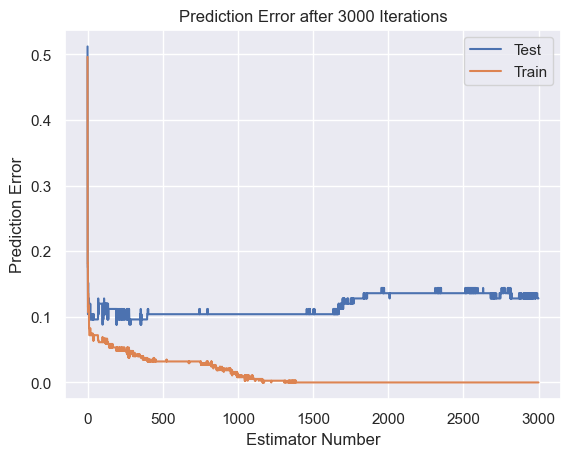

In [49]:
x = np.arange(3000)

sns.lineplot(x = x, y = test_scores, label = "Test")
sns.lineplot(x = x, y = train_scores, label = "Train")
plt.xlabel("Estimator Number")
plt.ylabel("Prediction Error")
plt.title("Prediction Error after 3000 Iterations")

Text(0.5, 1.0, 'Prediction Error after 200 Iterations')

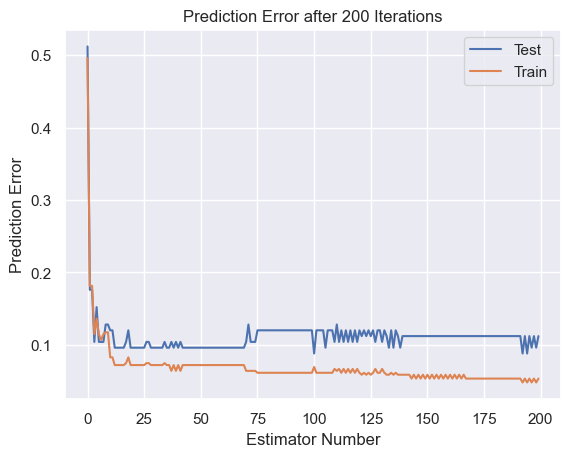

In [50]:
x = np.arange(200)

sns.lineplot(x = x, y = test_scores[:200], label = "Test")
sns.lineplot(x = x, y = train_scores[:200], label = "Train")
plt.xlabel("Estimator Number")
plt.ylabel("Prediction Error")
plt.title("Prediction Error after 200 Iterations")

Observation: The model is able to reduce its training prediction error as the number of estimators increases; however this is at the cost of performance on the test data. This is a strong indicator of overfitting to the training dataset.

Text(0.5, 1.0, 'Classifier Weights across 3000 Iterations')

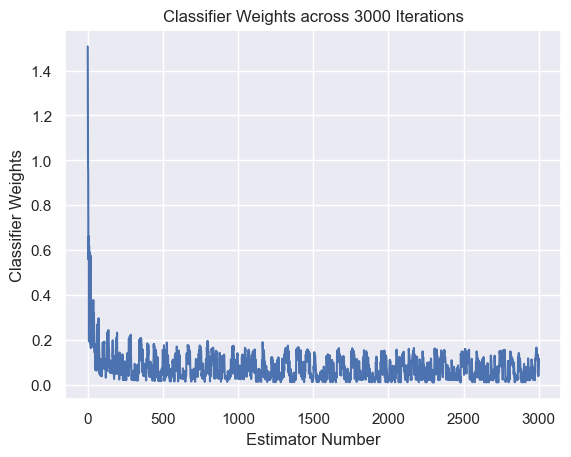

In [51]:
x = np.arange(3000)

sns.lineplot(x = x, y = ada.weights)
plt.xlabel("Estimator Number")
plt.ylabel("Classifier Weights")
plt.title("Classifier Weights across 3000 Iterations")

Text(0.5, 1.0, 'Weighted Error Rates across 3000 Iterations')

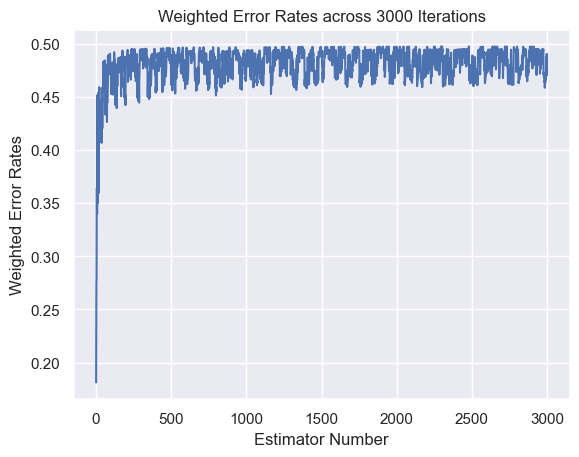

In [52]:
x = np.arange(3000)

sns.lineplot(x = x, y = ada.error_rates)
plt.xlabel("Estimator Number")
plt.ylabel("Weighted Error Rates")
plt.title("Weighted Error Rates across 3000 Iterations")

Text(0.5, 1.0, 'Accuracy on Training Set after 3000 Iterations')

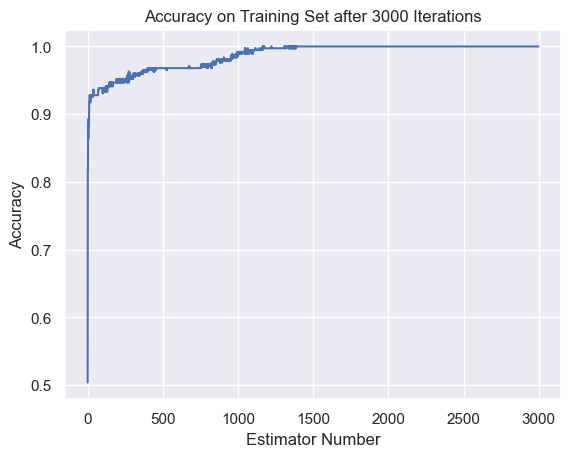

In [58]:
x = np.arange(3000)
scores = 1- train_scores

sns.lineplot(x = x, y = scores)
plt.xlabel("Estimator Number")
plt.ylabel("Accuracy")
plt.title("Accuracy on Training Set after 3000 Iterations")

Text(0.5, 1.0, 'Accuracy on Training Set after 200 Iterations')

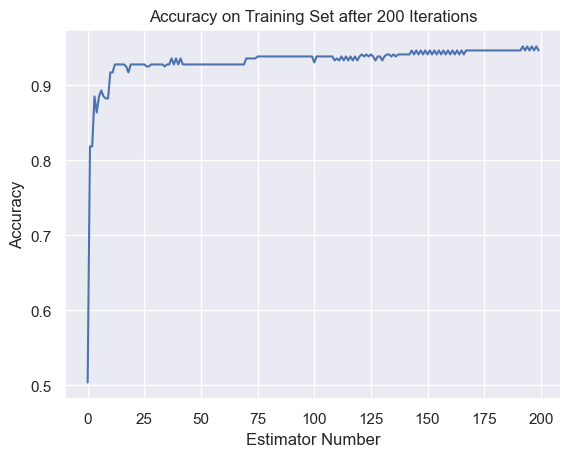

In [59]:
x = np.arange(200)

sns.lineplot(x = x, y = scores[:200])
plt.xlabel("Estimator Number")
plt.ylabel("Accuracy")
plt.title("Accuracy on Training Set after 200 Iterations")

Plotting Decision Boundaries

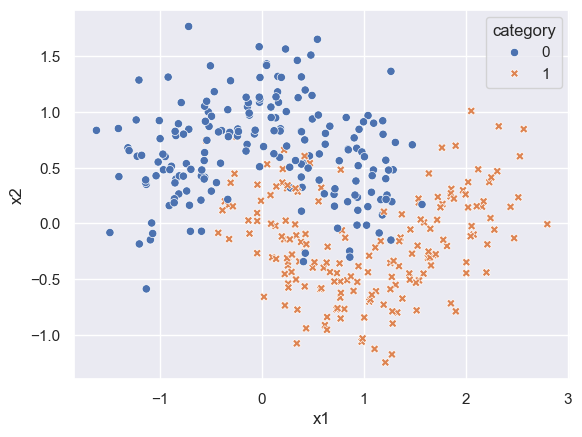

In [55]:
sns.scatterplot(data = moon_train, x = "x1", y= "x2", hue = "category", style = "category")
y_min, y_max = plt.gca().get_ylim()
x_min, x_max = plt.gca().get_xlim()

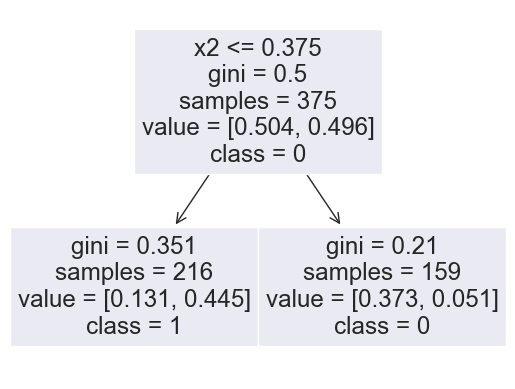

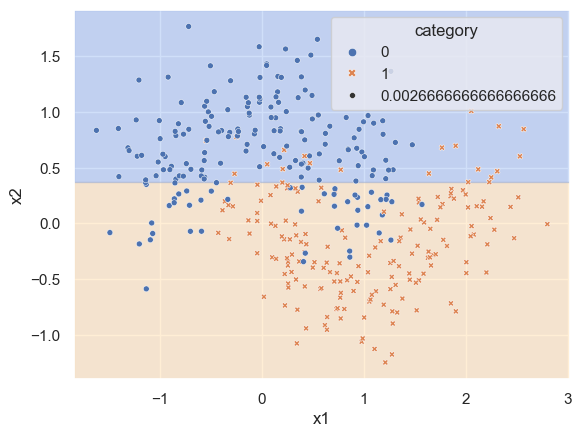

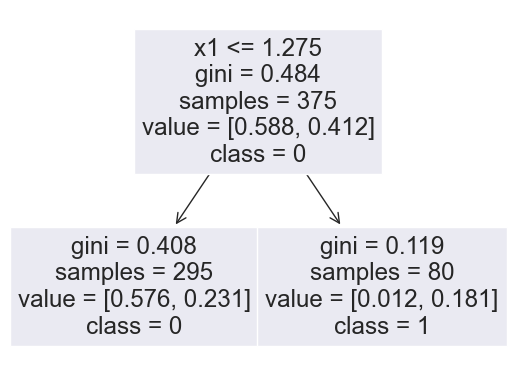

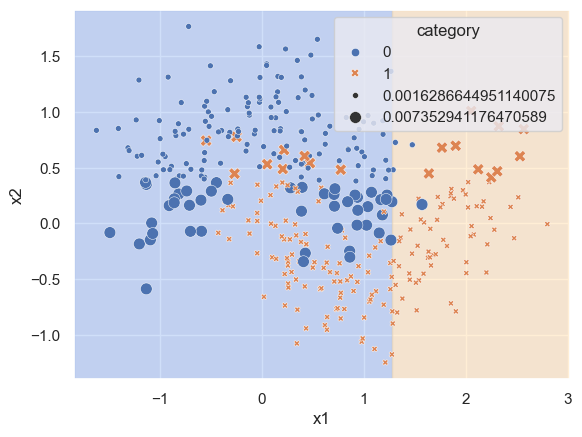

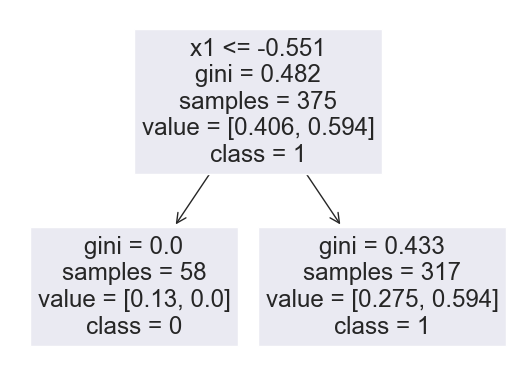

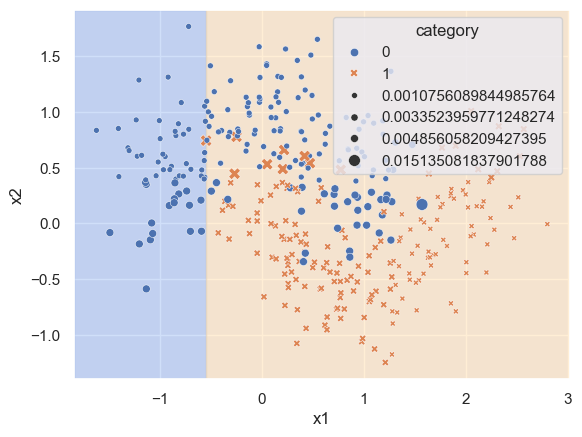

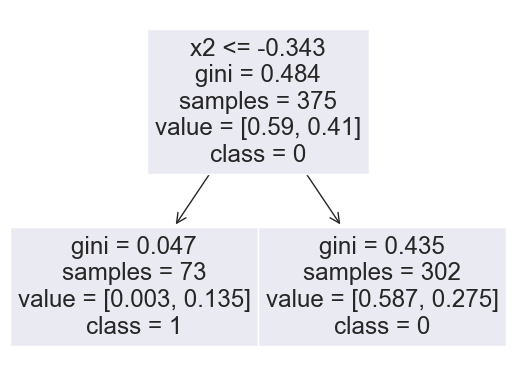

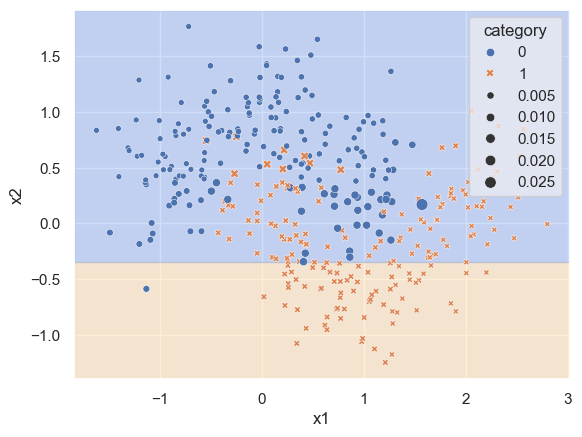

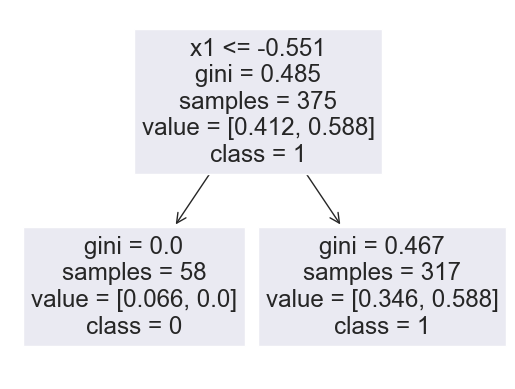

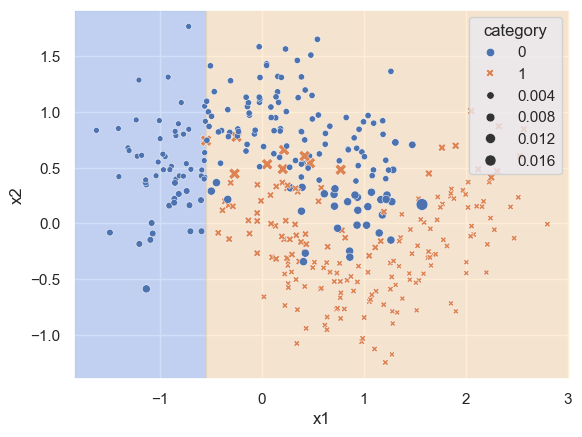

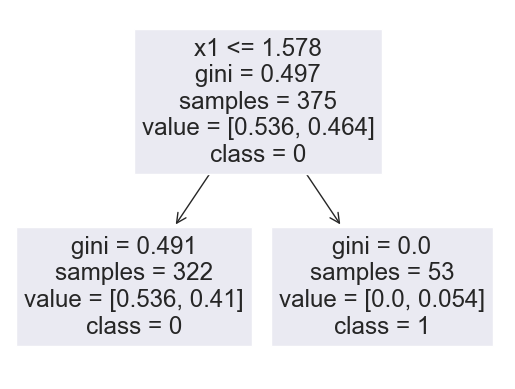

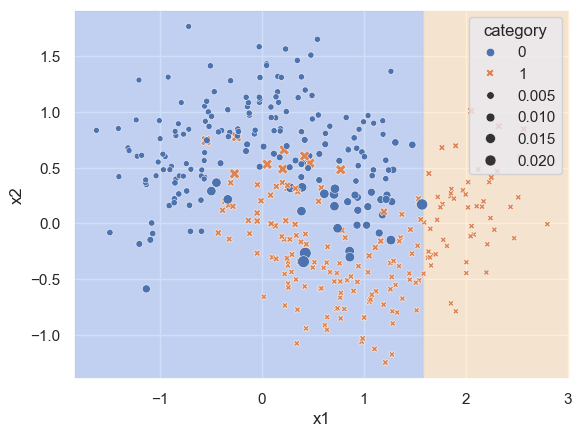

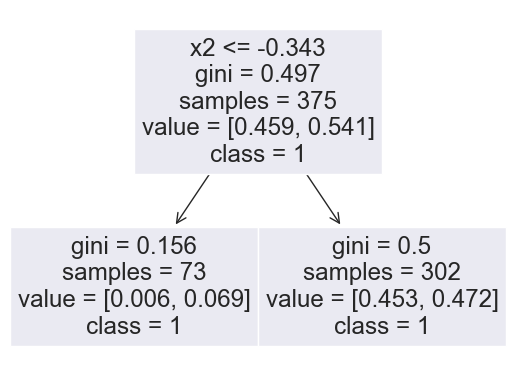

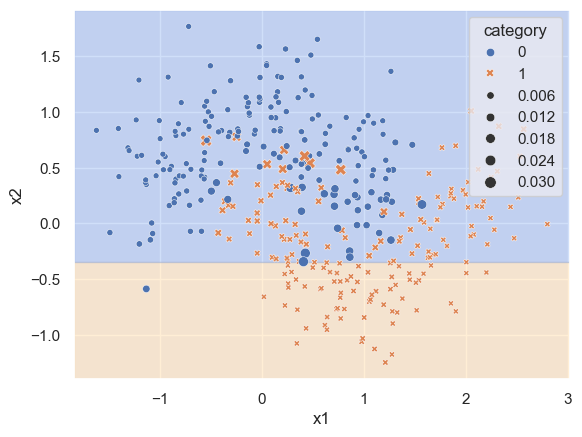

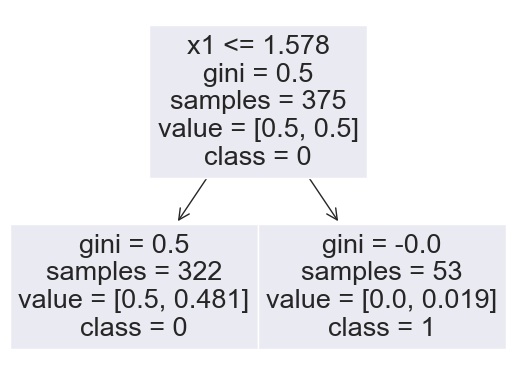

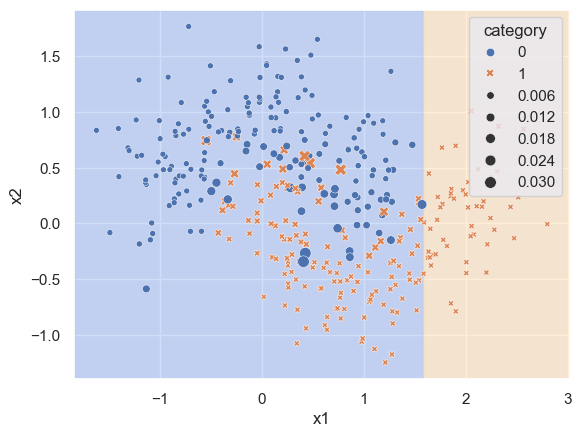

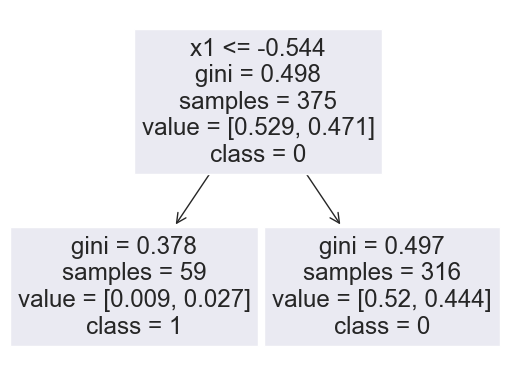

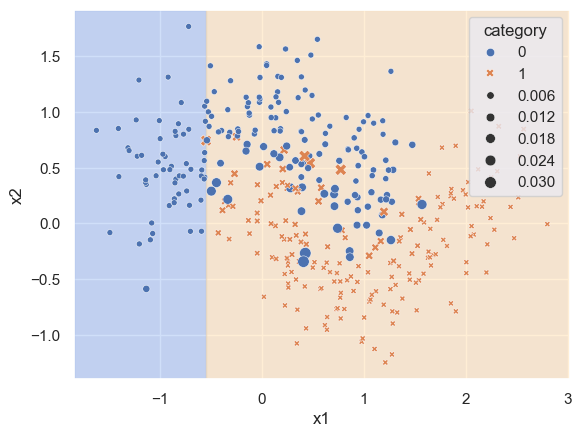

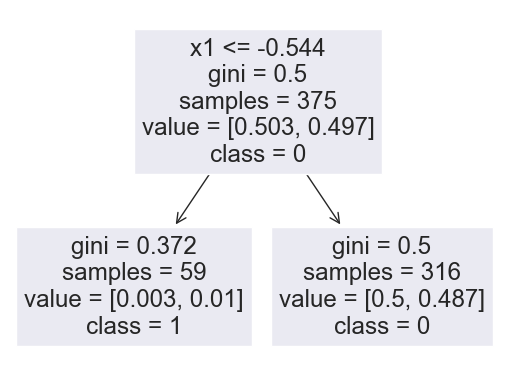

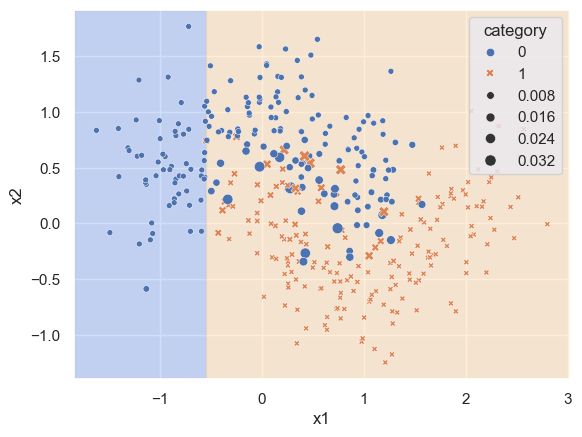

In [56]:
from sklearn.tree import plot_tree

indices = [0, 1, 2, 3, 4, 14, 20, 50, 100, 1000]

for index in indices:
    plt.clf()
    plot_tree(ada.classifiers[index].classifier, feature_names= ["x1", "x2"], class_names = ["0", "1"])
    plt.show()

    plt.clf()
    threshold = ada.classifiers[index].classifier.tree_.threshold[0]
    feature = ada.classifiers[index].classifier.tree_.feature[0]
    weight = ada.classifiers[index].sample_weights
    if feature == 1:
        plt.axhspan(ymin= y_min, ymax = threshold, color = "navajowhite", alpha = 0.5)
        plt.axhspan(ymin= threshold, ymax = y_max, color = "cornflowerblue", alpha = 0.3)
    else:
        plt.axvspan(xmin = x_min, xmax = threshold, color = "cornflowerblue", alpha = 0.3)
        plt.axvspan(xmin= threshold, xmax = x_max, color = "navajowhite", alpha = 0.5)
          
    sns.scatterplot(data = moon_train, x = "x1", y= "x2", hue = "category", style = "category", size = weight)
    plt.gca().set_xlim(x_min, x_max)
    plt.gca().set_ylim(y_min, y_max)
    plt.show()


Plotting Decision Boundaries for Ensemble Models creating from AdaBoosting

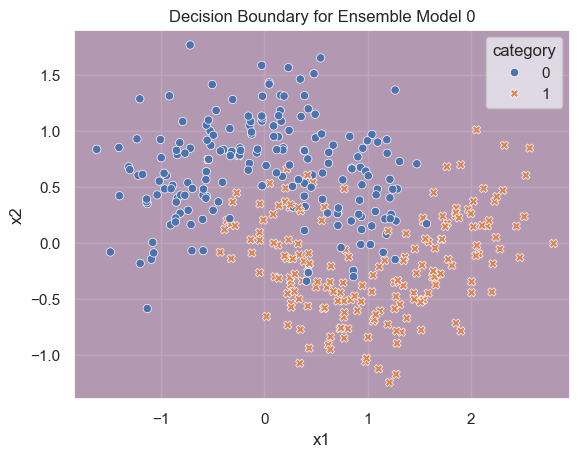

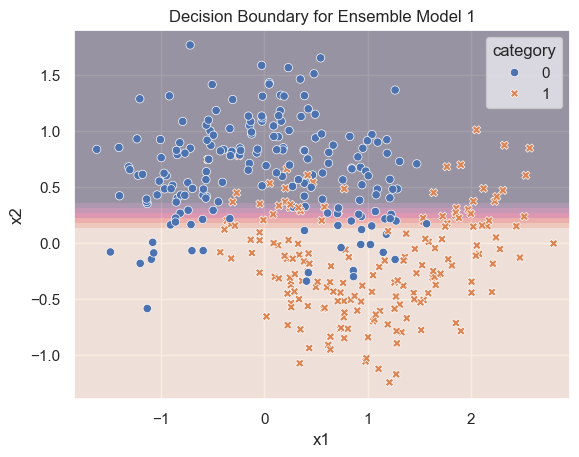

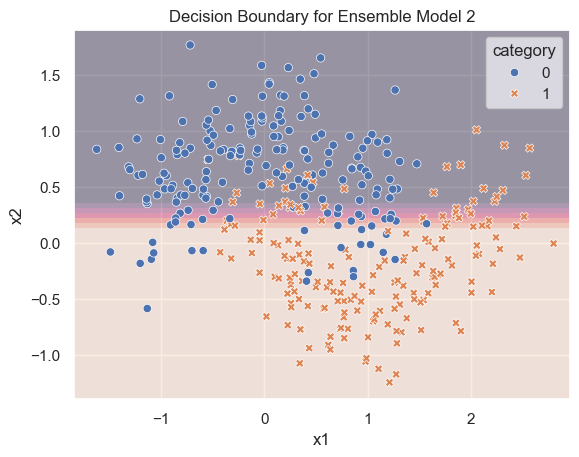

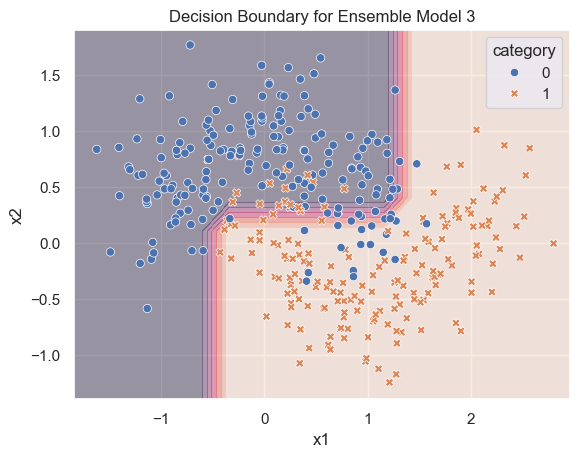

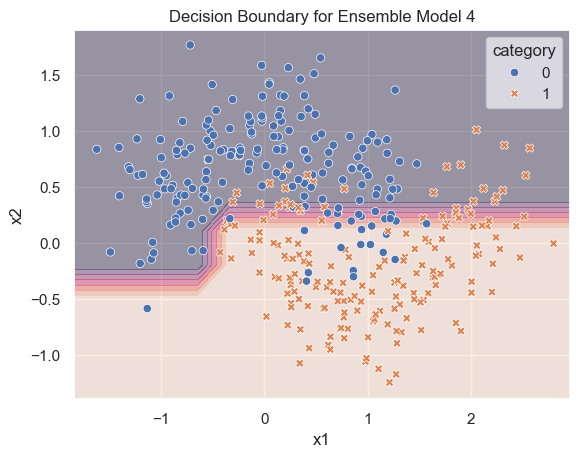

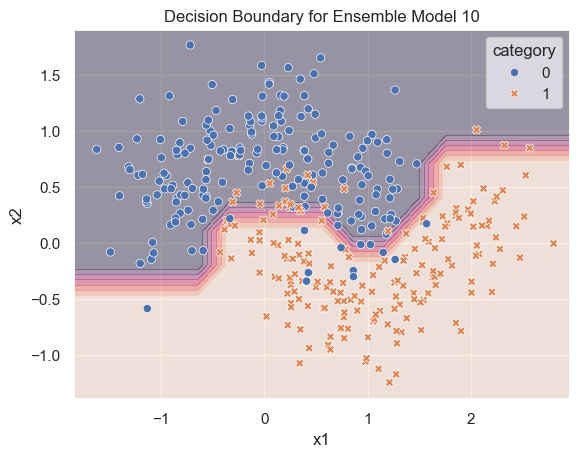

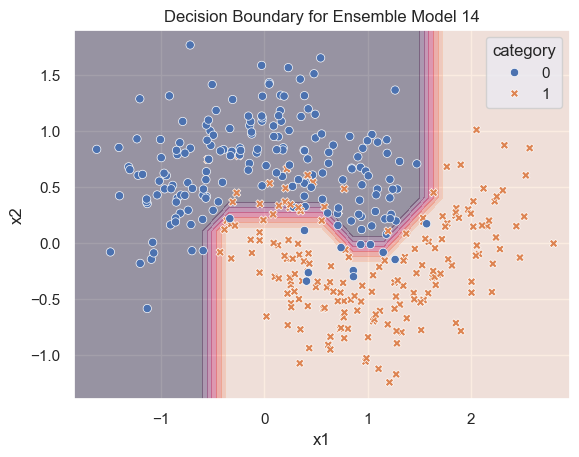

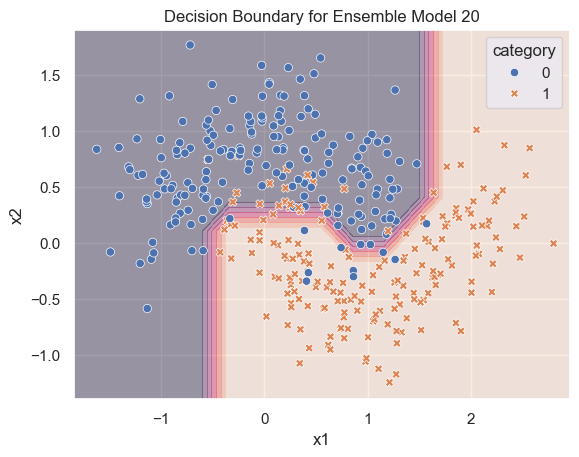

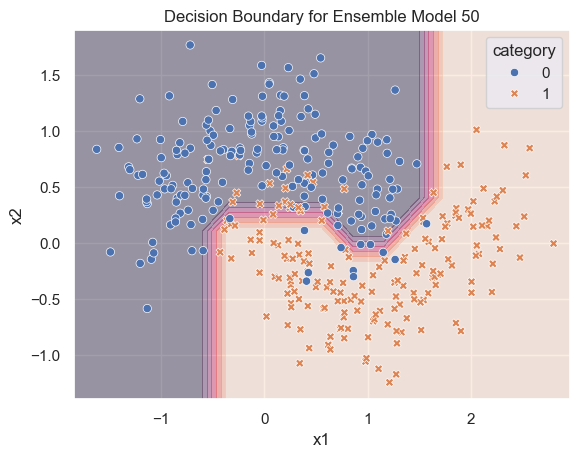

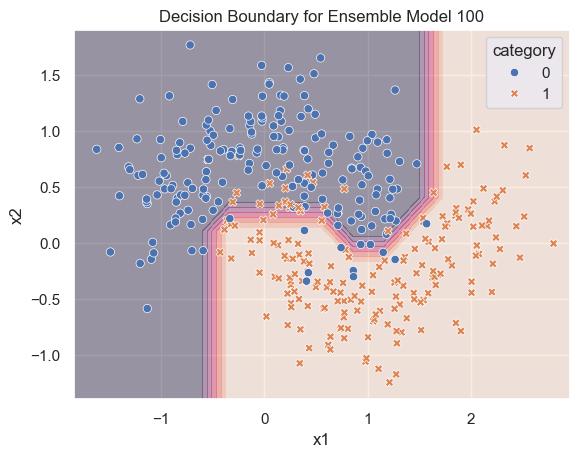

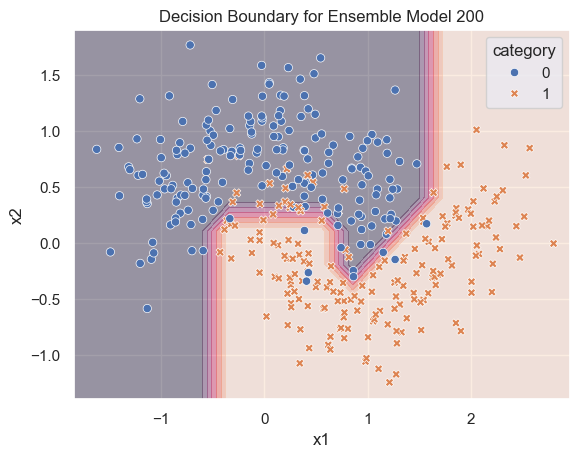

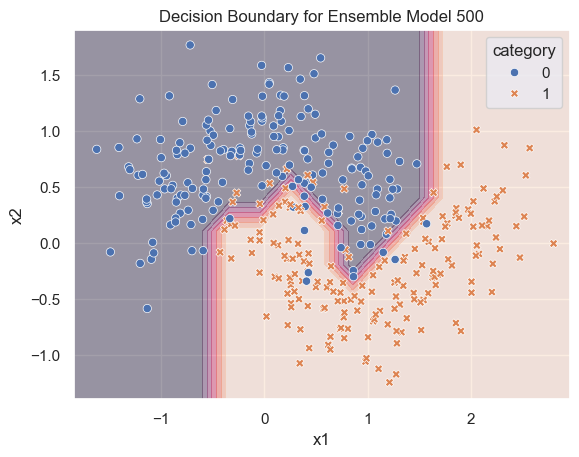

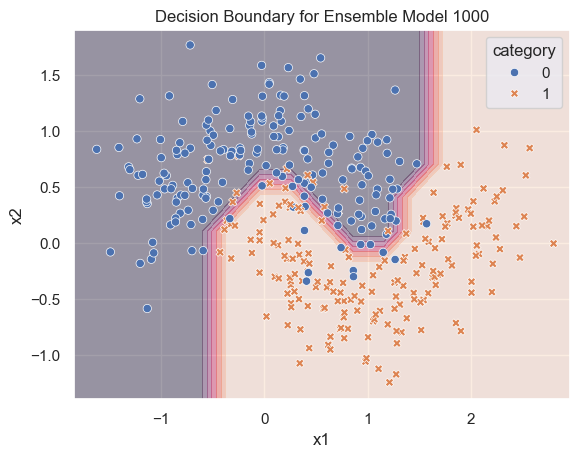

In [57]:
# Basic meshgrid test

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.3),
                     np.arange(y_min, y_max, 0.3))

# Combine xx and yy into a single DataFrame
df_grid = pd.DataFrame({'x1': xx.ravel(), 'x2': yy.ravel()})

indices = [0, 1, 2, 3, 4, 10, 14, 20, 50, 100, 200, 500, 1000]

for index in indices:
    # Predict the labels for all the points in the grid
    Z = ada.predict(df_grid, clf_stop = index)

    # Reshape Z to the shape of xx and yy
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary and the data points
    plt.title(f"Decision Boundary for Ensemble Model {index}")
    plt.contourf(xx, yy, Z, alpha=0.4)
    sns.scatterplot(data = moon_train, x = "x1", y= "x2", hue = "category", style = "category")
    plt.show()

### Discussion

I have gained a deeper understanding of how ensemble models can be made more powerful from several weaker models. I can easily see how flexible this machine learning technique is through the use of more than just DecisionTree stumps to create a model that takes advantage of several machine learning algorithms at once. Moreover, the plotting of accuracy for the training and test dataset demonstrates the dangers of overfitting and letting a model generalize. 